# Credit Card Fraud Detection

This project demonstrates a complete machine learning workflow for detecting fraudulent credit card transactions using classical algorithms and scikit-learn.  
The dataset is highly imbalanced, so the pipeline includes techniques to handle this challenge and improve detection performance.

## Dataset Overview

The **Kaggle Credit Card Fraud Detection Dataset** contains transactions made by European cardholders in September 2013.  
It includes **284,807 transactions over two days**, but only **492 are fraudulent (0.172%)**.  
This makes it a typical imbalanced classification problem, where fraudulent transactions are extremely rare.

**Dataset Features:**
- **V1–V28**: PCA-transformed features to protect sensitive information  
- **Time**: Seconds elapsed between each transaction and the first transaction in the dataset  
- **Amount**: Transaction amount  
- **Class**: Target variable  
  - `0` = Legitimate transaction  
  - `1` = Fraudulent transaction  

## Tools and Algorithms

**Core Libraries:**
- **pandas & numpy** → Data manipulation and numerical operations  
- **scikit-learn** → Machine learning algorithms and preprocessing  
- **matplotlib & seaborn** → Data visualization  
- **imbalanced-learn** → Specialized tools for handling imbalanced datasets  

**Algorithms Used:**
- **Logistic Regression** → Simple baseline model for quick benchmarking  
- **Random Forest** → Ensemble method that combines multiple decision trees  
- **XGBoost** → Gradient boosting algorithm with strong predictive performance  

**Key Techniques:**
- **SMOTE (Synthetic Minority Oversampling Technique)** → Balances the dataset by creating synthetic examples of the minority class  
- **Standard Scaling** → Normalizes features so models train more effectively  
- **Outlier Detection (IQR Method)** → Identifies and handles extreme values that could distort the model  
- **Cross-validation** → Ensures reliable performance estimates by testing the model on multiple data splits  


## Section 1: Environment Setup and Library Installation

In [43]:
# Install required libraries
!pip install imbalanced-learn xgboost -q

# Import core libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb

# Configure visualization settings
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## Section 2: Data Loading and Initial Inspection

In [44]:
# Load the dataset from online source
url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
df = pd.read_csv(url)

print("Dataset loaded successfully!")
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset loaded successfully!
Dataset Shape: (284807, 31)
Memory Usage: 67.36 MB


In [45]:
# Display basic dataset information
print("=== DATASET INFORMATION ===")
print(f"Dataset Shape: {df.shape}")
print(f"Total Features: {df.shape[1]}")
print(f"Total Samples: {df.shape[0]:,}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
df.head()

=== DATASET INFORMATION ===
Dataset Shape: (284807, 31)
Total Features: 31
Total Samples: 284,807
Memory Usage: 67.36 MB


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [46]:
# Display basic statistical summary
print("\n=== STATISTICAL SUMMARY ===")
df.describe()



=== STATISTICAL SUMMARY ===


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Section 3: Data Quality Assessment

**Purpose**: Check for missing values, data types, and basic data quality issues before proceeding with analysis.

In [47]:
# Check for missing values
print("=== MISSING VALUES ANALYSIS ===")

missing_values = df.isnull().sum()
missing_df = missing_values[missing_values > 0].reset_index()
missing_df.columns = ['Column', 'Missing Values']

print(f"Total missing values: {missing_values.sum()}")

if missing_values.sum() == 0:
    print("No missing values found in the dataset!")
else:
    print(missing_df)

# Check data types
print("\n=== DATA TYPES ===")
print(df.dtypes)


=== MISSING VALUES ANALYSIS ===
Total missing values: 0
No missing values found in the dataset!

=== DATA TYPES ===
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


## Section 4: Target Variable Analysis

**Purpose**: Analyze the distribution of fraud vs normal transactions to understand class imbalance.

In [48]:
# Analyze target variable distribution
print("=== TARGET VARIABLE ANALYSIS ===")

class_distribution = df['Class'].value_counts().reset_index()
class_distribution.columns = ['Class', 'Count']
class_distribution['Percentage'] = (class_distribution['Count'] / len(df) * 100).round(3)

print(class_distribution)

fraud_percentage = df['Class'].mean() * 100
normal_percentage = 100 - fraud_percentage

print(f"\nFraud Percentage: {fraud_percentage:.3f}%")
print(f"Normal Percentage: {normal_percentage:.3f}%")

=== TARGET VARIABLE ANALYSIS ===
   Class   Count  Percentage
0      0  284315      99.827
1      1     492       0.173

Fraud Percentage: 0.173%
Normal Percentage: 99.827%


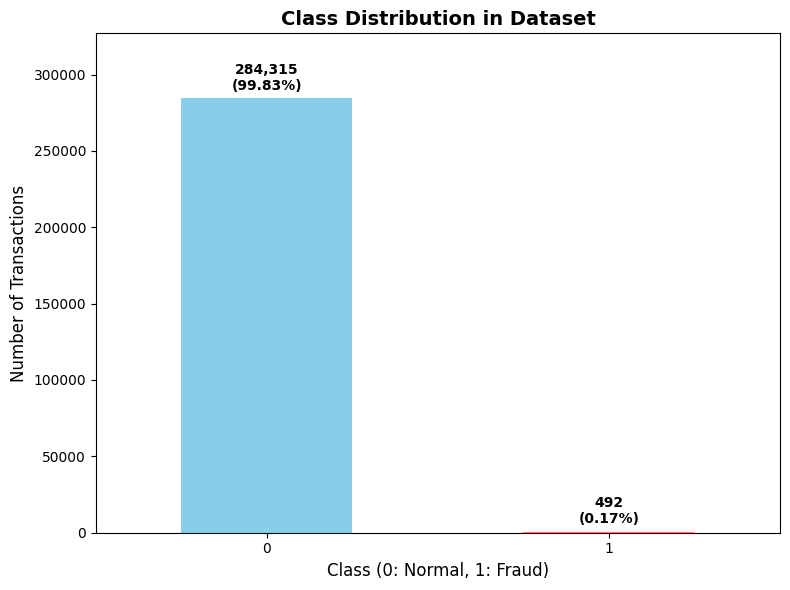

In [49]:
# Visualize class distribution
counts = df['Class'].value_counts()
total = len(df)

fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])

ax.set_title('Class Distribution in Dataset', fontweight='bold', fontsize=14)
ax.set_xlabel('Class (0: Normal, 1: Fraud)', fontsize=12)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.set_ylim(0, counts.max() * 1.15)

# Add percentage labels on bars
for i, v in enumerate(counts):
    ax.text(i, v + (counts.max() * 0.02),
            f'{v:,}\n({v/total*100:.2f}%)',
            ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Section 5: Exploratory Data Analysis

**Purpose**: Explore key features like Amount and Time to understand their distributions and relationship with fraud.

In [50]:
# Analyze Amount and Time features
print("=== FEATURE ANALYSIS ===")
print(f"Amount Statistics:")
print(df['Amount'].describe())
print(f"\nAmount range: ${df['Amount'].min():.2f} to ${df['Amount'].max():.2f}")

print(f"\nTime Statistics:")
print(df['Time'].describe())

=== FEATURE ANALYSIS ===
Amount Statistics:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

Amount range: $0.00 to $25691.16

Time Statistics:
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64


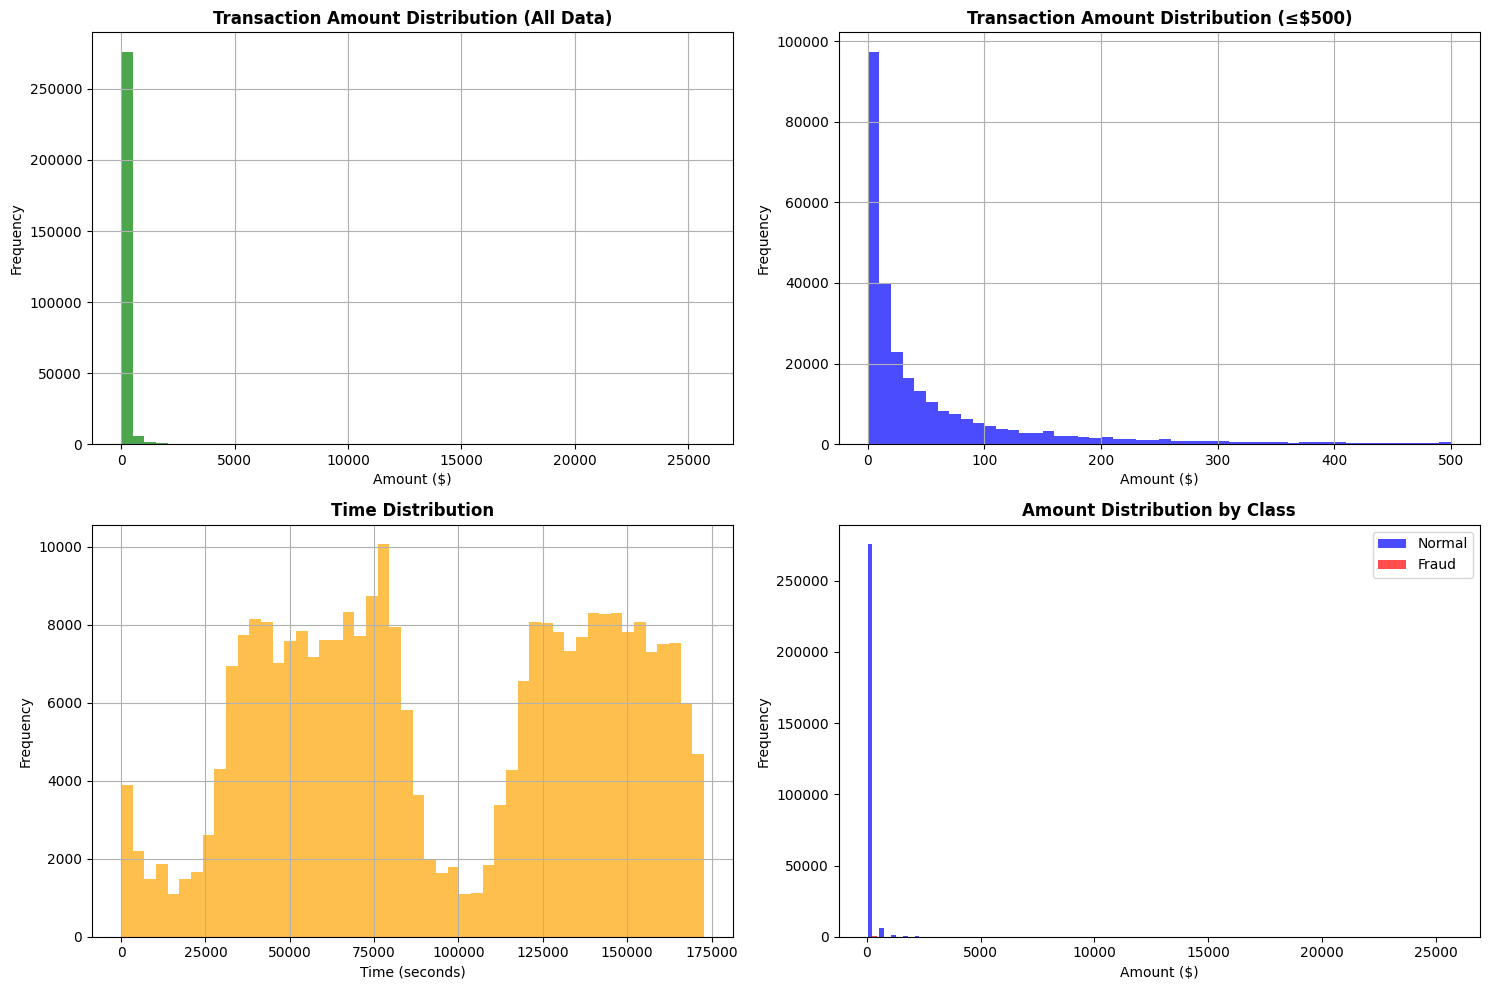

In [51]:
# Visualize Amount and Time distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Amount distribution - all data
df['Amount'].hist(bins=50, ax=axes[0,0], alpha=0.7, color='green')
axes[0,0].set_title('Transaction Amount Distribution (All Data)', fontweight='bold')
axes[0,0].set_xlabel('Amount ($)')
axes[0,0].set_ylabel('Frequency')

# Amount distribution - limited scale for better view
df[df['Amount'] <= 500]['Amount'].hist(bins=50, ax=axes[0,1], alpha=0.7, color='blue')
axes[0,1].set_title('Transaction Amount Distribution (≤$500)', fontweight='bold')
axes[0,1].set_xlabel('Amount ($)')
axes[0,1].set_ylabel('Frequency')

# Time distribution
df['Time'].hist(bins=50, ax=axes[1,0], alpha=0.7, color='orange')
axes[1,0].set_title('Time Distribution', fontweight='bold')
axes[1,0].set_xlabel('Time (seconds)')
axes[1,0].set_ylabel('Frequency')

# Amount by class comparison
fraud_amounts = df[df['Class']==1]['Amount']
normal_amounts = df[df['Class']==0]['Amount']
axes[1,1].hist([normal_amounts, fraud_amounts], bins=50, alpha=0.7,
               label=['Normal', 'Fraud'], color=['blue', 'red'])
axes[1,1].set_title('Amount Distribution by Class', fontweight='bold')
axes[1,1].set_xlabel('Amount ($)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()


## Section 6: Outlier Detection and Analysis

**Purpose**: Identify outliers in the Amount feature and analyze their impact on fraud detection.

In [52]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in Amount feature
amount_outliers, amt_lower, amt_upper = detect_outliers_iqr(df, 'Amount')

print("=== OUTLIER ANALYSIS ===")
print(f"Amount Outliers Detected: {len(amount_outliers)} ({len(amount_outliers)/len(df)*100:.2f}%)")
print(f"Amount Lower Bound: ${amt_lower:.2f}")
print(f"Amount Upper Bound: ${amt_upper:.2f}")

# Analyze outliers by class
normal_outliers = amount_outliers[amount_outliers['Class'] == 0]
fraud_outliers = amount_outliers[amount_outliers['Class'] == 1]

print(f"\nNormal transactions with outlier amounts: {len(normal_outliers)}")
print(f"Fraud transactions with outlier amounts: {len(fraud_outliers)}")
print(f"Percentage of fraud cases among amount outliers: {len(fraud_outliers)/len(amount_outliers)*100:.2f}%")

=== OUTLIER ANALYSIS ===
Amount Outliers Detected: 31904 (11.20%)
Amount Lower Bound: $-101.75
Amount Upper Bound: $184.51

Normal transactions with outlier amounts: 31813
Fraud transactions with outlier amounts: 91
Percentage of fraud cases among amount outliers: 0.29%


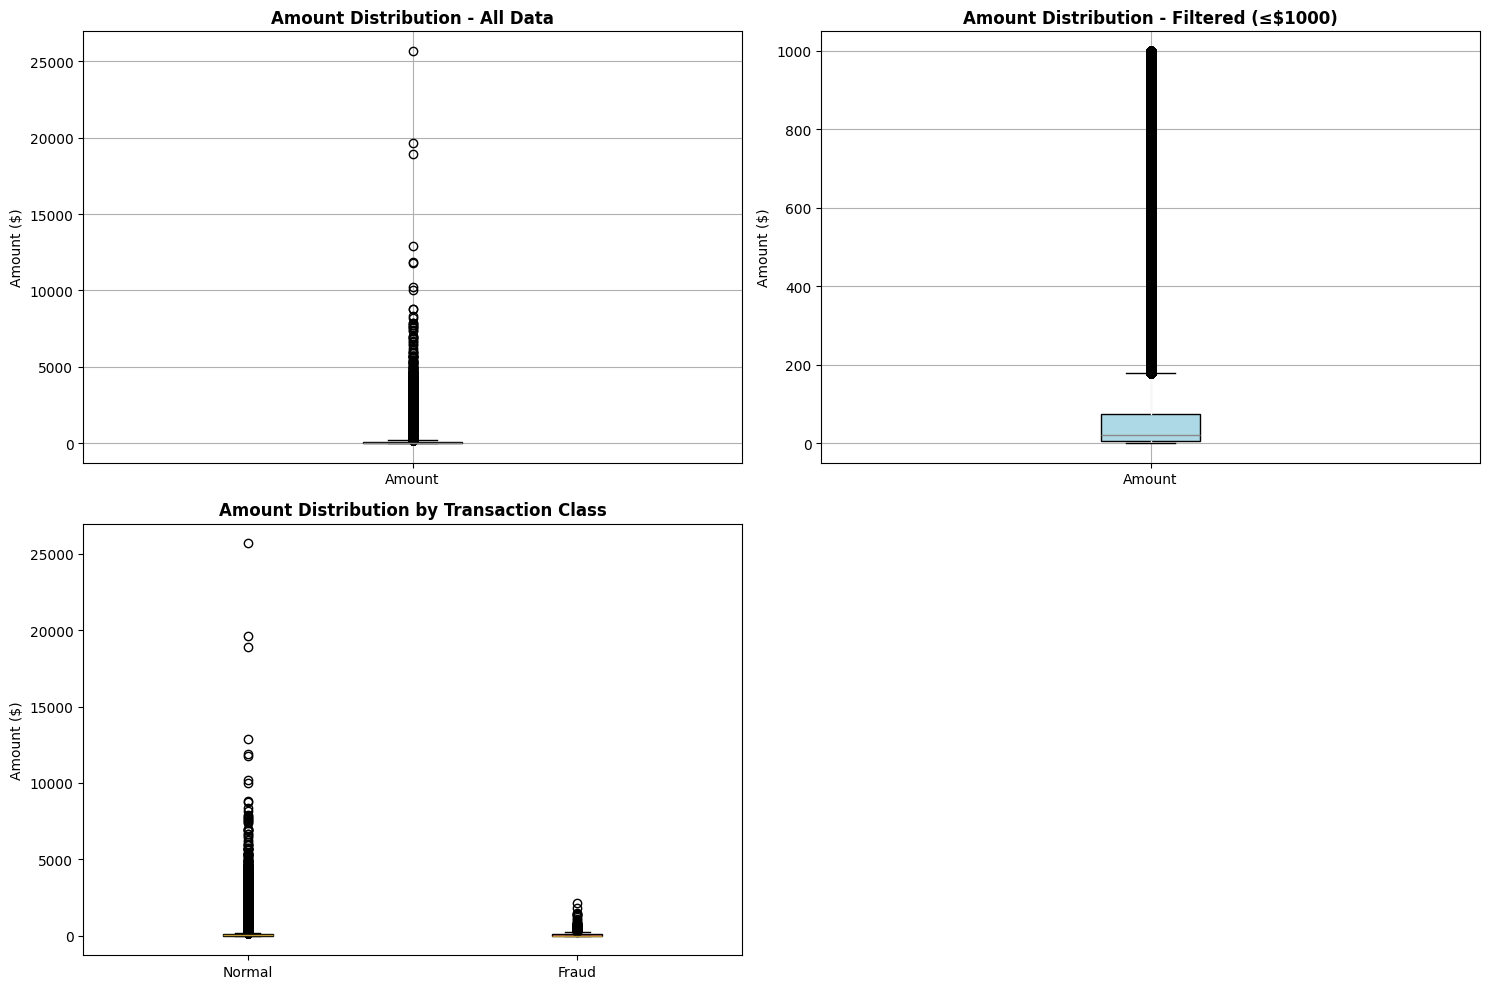

In [72]:
# Visualize outliers using box plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Box plot for all amount data
df.boxplot(column='Amount', ax=axes[0,0], patch_artist=True, boxprops=dict(facecolor="lightgray"))
axes[0,0].set_title('Amount Distribution - All Data', fontweight='bold')
axes[0,0].set_ylabel('Amount ($)')

# Box plot for filtered amount data (better visibility)
df[df['Amount'] <= 1000].boxplot(column='Amount', ax=axes[0,1], patch_artist=True, boxprops=dict(facecolor="lightblue"))
axes[0,1].set_title('Amount Distribution - Filtered (≤$1000)', fontweight='bold')
axes[0,1].set_ylabel('Amount ($)')

# Box plot comparison by class
fraud_normal_amounts = [df[df['Class']==0]['Amount'], df[df['Class']==1]['Amount']]
box_plot = axes[1,0].boxplot(fraud_normal_amounts, labels=['Normal', 'Fraud'], patch_artist=True)
axes[1,0].set_title('Amount Distribution by Transaction Class', fontweight='bold')
axes[1,0].set_ylabel('Amount ($)')

# Color the boxplots
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Hide the empty subplot
axes[1,1].set_visible(False)

plt.tight_layout()
plt.show()


## Section 7: Data Preprocessing - Outlier Treatment

**Purpose**: Apply outlier treatment using capping method to reduce the impact of extreme values.

In [53]:
# Apply outlier treatment using capping at 99th percentile
df_processed = df.copy()

amount_99th = df_processed['Amount'].quantile(0.99)
print(f"=== OUTLIER TREATMENT ===")
print(f"99th percentile of Amount: ${amount_99th:.2f}")

original_max = df_processed['Amount'].max()
df_processed['Amount'] = np.where(df_processed['Amount'] > amount_99th,
                                 amount_99th, df_processed['Amount'])

print(f"Original max amount: ${original_max:.2f}")
print(f"After capping max amount: ${df_processed['Amount'].max():.2f}")
print(f"Number of values capped: {(df['Amount'] > amount_99th).sum()}")


=== OUTLIER TREATMENT ===
99th percentile of Amount: $1017.97
Original max amount: $25691.16
After capping max amount: $1017.97
Number of values capped: 2849


In [54]:
# Analyze outliers by class
print("\n=== OUTLIER BREAKDOWN BY CLASS ===")
normal_outliers = amount_outliers[amount_outliers['Class'] == 0]
fraud_outliers = amount_outliers[amount_outliers['Class'] == 1]

print(f"Normal transactions with outlier amounts: {len(normal_outliers)}")
print(f"Fraud transactions with outlier amounts: {len(fraud_outliers)}")
print(f"Percentage of fraud cases among amount outliers: {len(fraud_outliers)/len(amount_outliers)*100:.2f}%")



=== OUTLIER BREAKDOWN BY CLASS ===
Normal transactions with outlier amounts: 31813
Fraud transactions with outlier amounts: 91
Percentage of fraud cases among amount outliers: 0.29%


## Section 8: Feature–Target Separation
**Purpose:** Separate the feature set (`X`) from the target variable (`y`).  

In [56]:
# Separate features and target variable
X = df_processed.drop(['Class'], axis=1)
y = df_processed['Class']

print("=== FEATURE AND TARGET SEPARATION ===")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {list(X.columns)}")
print(f"Target name: {y.name}")

=== FEATURE AND TARGET SEPARATION ===
Features shape: (284807, 30)
Target shape: (284807,)
Feature columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
Target name: Class


## Section 9: Train–Test Split
**Purpose:** Split the data into training and test sets before any scaling or oversampling, to prevent **data leakage**.

In [57]:
# Perform stratified train-test split BEFORE any preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("=== TRAIN-TEST SPLIT RESULTS ===")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"Training fraud percentage: {y_train.mean()*100:.3f}%")
print(f"\nTesting set class distribution:")
print(y_test.value_counts())
print(f"Testing fraud percentage: {y_test.mean()*100:.3f}%")

=== TRAIN-TEST SPLIT RESULTS ===
Training set shape: (199364, 30)
Testing set shape: (85443, 30)

Training set class distribution:
Class
0    199020
1       344
Name: count, dtype: int64
Training fraud percentage: 0.173%

Testing set class distribution:
Class
0    85295
1      148
Name: count, dtype: int64
Testing fraud percentage: 0.173%


## Section 10: Feature Scaling
**Purpose:** Standardize numerical features so they all have a similar scale, which helps certain algorithms like Logistic Regression and SVM perform better.  
**Reason in this Dataset:** The `Amount` and `Time` columns have very different ranges, which could bias the model. Scaling ensures fair feature contribution.  
**Important:** Scaling is done **only on the training data** and then applied to the test data to avoid information leaking from the test set.

In [58]:
# Initialize and fit StandardScaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Transform test data with fitted scaler

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("=== FEATURE SCALING RESULTS (NO DATA LEAKAGE) ===")
print("Scaling completed successfully!")
print(f"Scaled training features shape: {X_train_scaled.shape}")
print(f"Scaled testing features shape: {X_test_scaled.shape}")
print(f"\nTraining set statistics after scaling:")
print(X_train_scaled.describe().round(3))


=== FEATURE SCALING RESULTS (NO DATA LEAKAGE) ===
Scaling completed successfully!
Scaled training features shape: (199364, 30)
Scaled testing features shape: (85443, 30)

Training set statistics after scaling:
             Time          V1          V2          V3          V4          V5  \
count  199364.000  199364.000  199364.000  199364.000  199364.000  199364.000   
mean       -0.000       0.000      -0.000       0.000       0.000       0.000   
std         1.000       1.000       1.000       1.000       1.000       1.000   
min        -1.998     -28.694     -43.854     -31.796      -4.012     -81.990   
25%        -0.856      -0.467      -0.361      -0.585      -0.598      -0.499   
50%        -0.212       0.009       0.040       0.120      -0.015      -0.040   
75%         0.936       0.670       0.487       0.676       0.525       0.440   
max         1.640       1.248      13.304       6.174      11.911      25.086   

               V6          V7          V8          V9  ...  

## Section 11: SMOTE Application
**Purpose:** Handle the severe class imbalance by oversampling the minority class (fraud) using **SMOTE (Synthetic Minority Oversampling Technique)**.  
**How SMOTE Works:** Instead of simply duplicating existing fraud cases, SMOTE creates new synthetic fraud samples by interpolating between real fraud cases and their nearest neighbors.  
**Why in This Dataset:** With only 492 fraud cases, models might ignore the minority class completely. SMOTE helps the model learn fraud patterns more effectively.

In [59]:
# Apply SMOTE only to training data (already scaled and separated)
print("=== APPLYING SMOTE FOR DATA BALANCING (NO LEAKAGE) ===")
print("Original training set distribution:")
print(f"Normal: {(y_train==0).sum()} ({(y_train==0).mean()*100:.1f}%)")
print(f"Fraud: {(y_train==1).sum()} ({(y_train==1).mean()*100:.1f}%)")

# Use conservative sampling strategy to avoid overfitting
# Note: PCA-transformed features (V1-V28) are continuous, so SMOTE is appropriate
smote = SMOTE(random_state=42, sampling_strategy=0.1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE balancing (applied only to training data):")
print(f"Normal: {(y_train_balanced==0).sum()} ({(y_train_balanced==0).mean()*100:.1f}%)")
print(f"Fraud: {(y_train_balanced==1).sum()} ({(y_train_balanced==1).mean()*100:.1f}%)")
print(f"Total training samples increased from {len(X_train_scaled)} to {len(X_train_balanced)}")


=== APPLYING SMOTE FOR DATA BALANCING (NO LEAKAGE) ===
Original training set distribution:
Normal: 199020 (99.8%)
Fraud: 344 (0.2%)

After SMOTE balancing (applied only to training data):
Normal: 199020 (90.9%)
Fraud: 19902 (9.1%)
Total training samples increased from 199364 to 218922


## Section 12: Model Definition and Training Pipeline

**Purpose**: Define machine learning models and create proper training pipelines for comparison.

In [60]:
# Define machine learning models for comparison
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)
}

print("=== MACHINE LEARNING MODELS DEFINED ===")
print("Models selected for training and comparison:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"{i}. {model_name}")

print(f"\nTraining will be performed on balanced dataset with {len(X_train_balanced)} samples")
print("Testing will be performed on original unbalanced test set")


=== MACHINE LEARNING MODELS DEFINED ===
Models selected for training and comparison:
1. Logistic Regression
2. Random Forest
3. XGBoost

Training will be performed on balanced dataset with 218922 samples
Testing will be performed on original unbalanced test set


## Section 13: Model Training and Evaluation
**Purpose:** Train each model on the processed training data and evaluate performance on the untouched test set.  

In [61]:
# Initialize results storage
results = {}
trained_models = {}

print("=== MODEL TRAINING AND EVALUATION ===")
print("="*60)

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train the model on balanced training data
    model.fit(X_train_balanced, y_train_balanced)

    # Make predictions on original test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate performance metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'AUC-ROC': auc_score,
        'Average Precision': avg_precision,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    trained_models[name] = model

    print(f"{name} Training Complete!")
    print(f"  - AUC-ROC Score: {auc_score:.4f}")
    print(f"  - Average Precision: {avg_precision:.4f}")

# Identify best performing model
best_model_name = max(results.keys(), key=lambda k: results[k]['AUC-ROC'])
print(f"\n{'='*60}")
print(f"BEST PERFORMING MODEL: {best_model_name}")
print(f"AUC-ROC Score: {results[best_model_name]['AUC-ROC']:.4f}")
print(f"{'='*60}")


=== MODEL TRAINING AND EVALUATION ===

Training Logistic Regression...
Logistic Regression Training Complete!
  - AUC-ROC Score: 0.9678
  - Average Precision: 0.7197

Training Random Forest...
Random Forest Training Complete!
  - AUC-ROC Score: 0.9583
  - Average Precision: 0.8286

Training XGBoost...
XGBoost Training Complete!
  - AUC-ROC Score: 0.9767
  - Average Precision: 0.8323

BEST PERFORMING MODEL: XGBoost
AUC-ROC Score: 0.9767


## Section 14: Cross-Validation with Proper Pipeline

**Purpose**: Evaluate models more reliably by using multiple train-test splits with preprocessing steps built directly into the pipeline.

**Description**:  
Instead of relying on a single train-test split, we use **Stratified K-Fold Cross-Validation** with a pipeline that includes **StandardScaler** and **SMOTE** before the model.  
This way, scaling and oversampling happen **inside** each fold, using only training data in that fold, so there is **no data leakage**.  

Because our dataset has only **492 fraud cases (0.17%)**, results from a single split could vary a lot.  
Cross-validation gives a more trustworthy performance estimate and ensures the model is tested across different subsets of the data.  

**In this project**, we are using:
- **StratifiedKFold (5 splits)** → Keeps the same fraud/legit ratio in each fold  
- **StandardScaler** → Normalizes feature values for better model performance  
- **SMOTE** → Balances classes in each fold’s training set  
- **ROC-AUC scoring** → Measures how well the model ranks fraud vs. non-fraud transactions


In [62]:
# Implement proper cross-validation with pipeline to avoid data leakage
print("=== CROSS-VALIDATION WITH PROPER PIPELINE ===")

# Create pipelines that integrate preprocessing and modeling
cv_results = {}
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    # Create pipeline with scaling and SMOTE
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
        ('classifier', model)
    ])

    # Perform cross-validation on original training data
    cv_scores = cross_val_score(pipeline, X_train, y_train,
                               cv=cv_folds, scoring='roc_auc', n_jobs=-1)

    cv_results[name] = {
        'mean_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std(),
        'cv_scores': cv_scores
    }

    print(f"{name}:")
    print(f"  Mean CV AUC-ROC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print(f"\nBest CV Performance: {max(cv_results.keys(), key=lambda k: cv_results[k]['mean_cv_score'])}")


=== CROSS-VALIDATION WITH PROPER PIPELINE ===
Logistic Regression:
  Mean CV AUC-ROC: 0.9814 (+/- 0.0147)
Random Forest:
  Mean CV AUC-ROC: 0.9702 (+/- 0.0236)
XGBoost:
  Mean CV AUC-ROC: 0.9778 (+/- 0.0222)

Best CV Performance: Logistic Regression


## Section 15: Detailed Classification Reports

**Purpose**: Generate detailed classification reports for all models to understand their performance on fraud vs. non-fraud detection.

**Description**:  
For each model, we produce a **classification report** showing key metrics:  
- **Precision** → Of all transactions predicted as fraud, how many were actually fraud  
- **Recall (Sensitivity)** → Of all actual fraud transactions, how many we correctly identified  
- **F1-score** → The balance between precision and recall (useful for imbalanced datasets)  
- **ROC-AUC** → Measures how well the model separates fraud from non-fraud across all thresholds  

These metrics help compare models not just on accuracy, but on how well they handle the rare fraud cases in this highly imbalanced dataset.


In [63]:
# Generate detailed classification reports
print("=== DETAILED CLASSIFICATION REPORTS ===")
print("="*70)

for name in models.keys():
    print(f"\n{name.upper()}:")
    print("-" * len(name))
    print(classification_report(y_test, results[name]['y_pred'],
                              target_names=['Normal', 'Fraud'],
                              digits=4))

    # Additional metrics
    cm = confusion_matrix(y_test, results[name]['y_pred'])
    tn, fp, fn, tp = cm.ravel()

    print(f"Confusion Matrix Details:")
    print(f"  True Negatives (Correct Normal):  {tn:,}")
    print(f"  False Positives (False Alarms):   {fp:,}")
    print(f"  False Negatives (Missed Fraud):   {fn:,}")
    print(f"  True Positives (Detected Fraud):  {tp:,}")
    print(f"  Fraud Detection Rate: {tp/(tp+fn)*100:.1f}%")
    print(f"  False Alarm Rate: {fp/(fp+tn)*100:.3f}%")

=== DETAILED CLASSIFICATION REPORTS ===

LOGISTIC REGRESSION:
-------------------
              precision    recall  f1-score   support

      Normal     0.9997    0.9973    0.9985     85295
       Fraud     0.3465    0.8311    0.4891       148

    accuracy                         0.9970     85443
   macro avg     0.6731    0.9142    0.7438     85443
weighted avg     0.9986    0.9970    0.9976     85443

Confusion Matrix Details:
  True Negatives (Correct Normal):  85,063
  False Positives (False Alarms):   232
  False Negatives (Missed Fraud):   25
  True Positives (Detected Fraud):  123
  Fraud Detection Rate: 83.1%
  False Alarm Rate: 0.272%

RANDOM FOREST:
-------------
              precision    recall  f1-score   support

      Normal     0.9997    0.9998    0.9997     85295
       Fraud     0.8881    0.8041    0.8440       148

    accuracy                         0.9995     85443
   macro avg     0.9439    0.9019    0.9219     85443
weighted avg     0.9995    0.9995    0.9995 

## Section 16: Visualization – Confusion Matrices

**Purpose**: Create visual confusion matrices for all models to compare how well they identify fraud and normal transactions.

**Description**:  
A **confusion matrix** visually summarizes model predictions against actual outcomes:  
- **True Positives (TP)** → Fraud correctly predicted as fraud (successful detection)  
- **True Negatives (TN)** → Normal correctly predicted as normal (correct reassurance)  
- **False Positives (FP)** → Normal wrongly predicted as fraud (false alarm)  
- **False Negatives (FN)** → Fraud wrongly predicted as normal (missed detection – the most costly error)  

By visualizing these, we can instantly see which models minimize false negatives (critical for fraud detection) while keeping false positives reasonable.


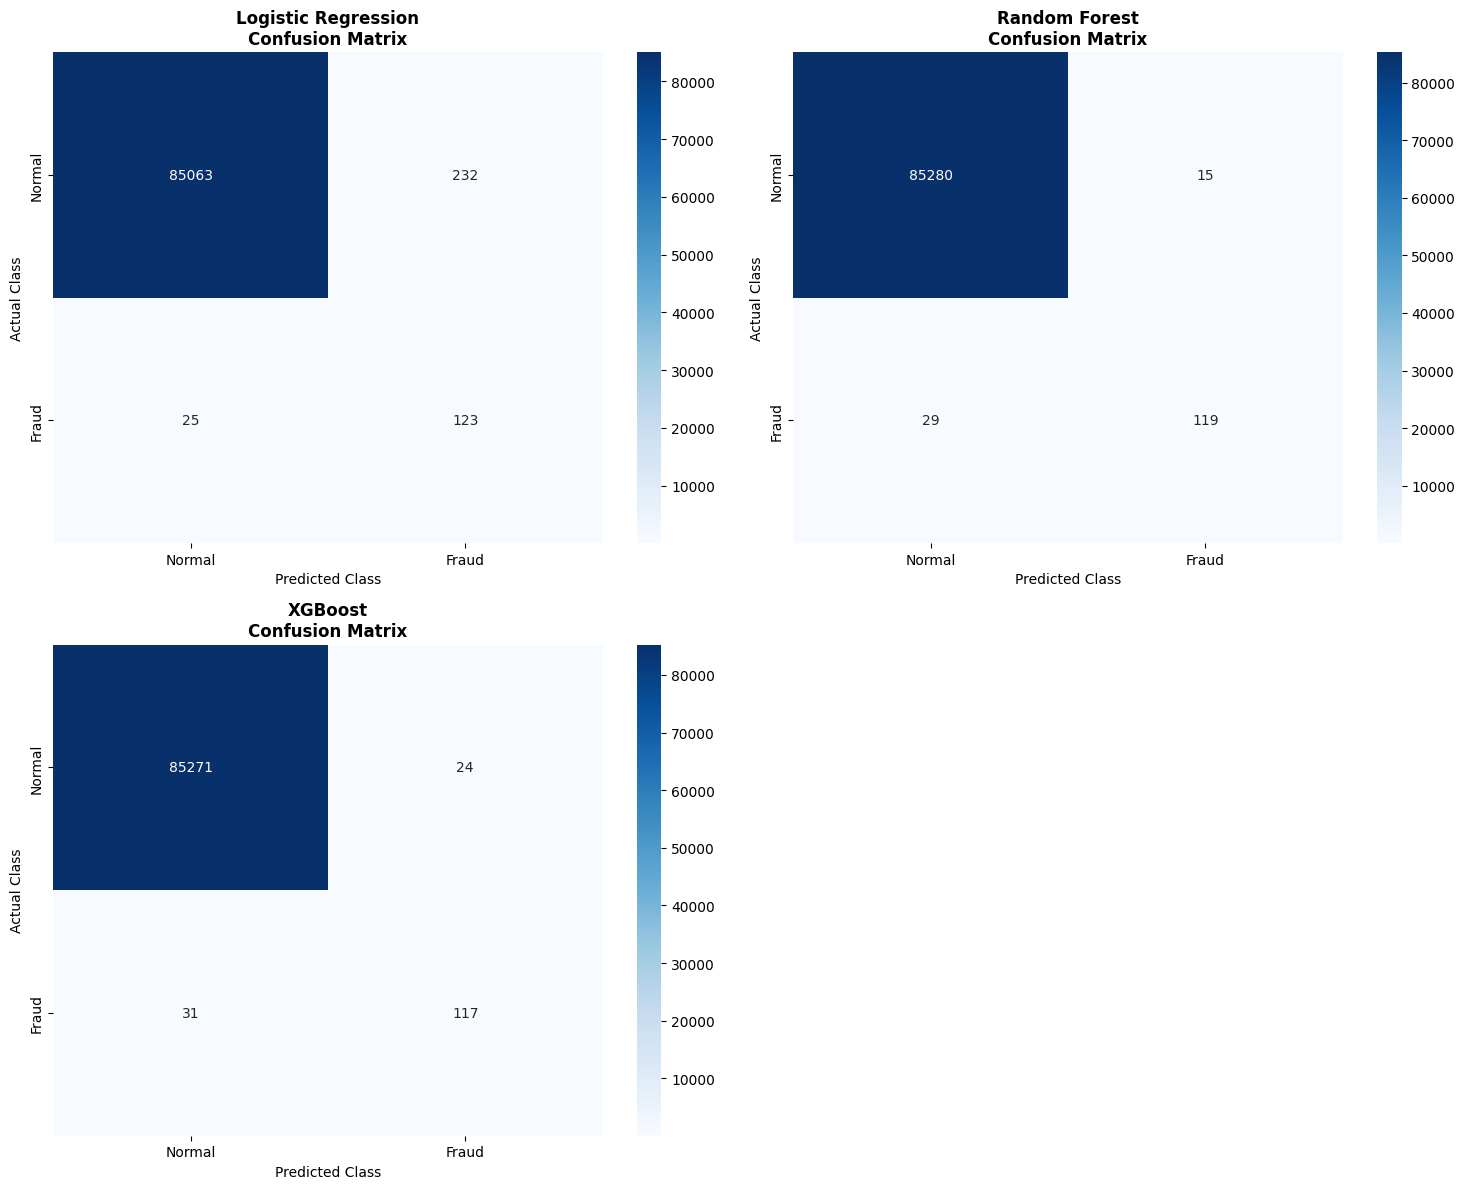

Model with highest fraud recall: Logistic Regression (0.8311)


In [71]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

fraud_recalls = {}  # Store recall for fraud detection

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Fraud'],
                yticklabels=['Normal', 'Fraud'])
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontweight='bold')
    axes[idx].set_xlabel('Predicted Class')
    axes[idx].set_ylabel('Actual Class')

    # Calculate recall for fraud detection (positive class)
    TP = cm[1, 1]
    FN = cm[1, 0]
    fraud_recalls[name] = TP / (TP + FN) if (TP + FN) > 0 else 0

# Hide the empty subplot
axes[3].set_visible(False)

plt.tight_layout()
plt.show()

# Print the best model for fraud recall
best_model = max(fraud_recalls, key=fraud_recalls.get)
print(f"Model with highest fraud recall: {best_model} ({fraud_recalls[best_model]:.4f})")


## Section 17: ROC and Precision-Recall Curves

**Purpose**: Visualize model performance across different classification thresholds using two key plots:  
- **ROC Curve**: Shows the trade-off between True Positive Rate (Recall) and False Positive Rate. AUC closer to 1.0 means better performance; 0.5 means random guessing.  
- **Precision-Recall Curve**: Especially useful for imbalanced datasets. Shows the trade-off between how many predicted frauds are correct (Precision) and how many actual frauds are caught (Recall). Higher curves indicate better performance.

**Interpretation**:
- **ROC Curve**: The steeper the curve toward the top-left corner, the better the model is at distinguishing fraud from normal transactions.  
- **Precision-Recall Curve**: In fraud detection, this is often more informative than ROC because it focuses on the rare positive class; higher precision and recall mean fewer false alarms and more fraud caught.

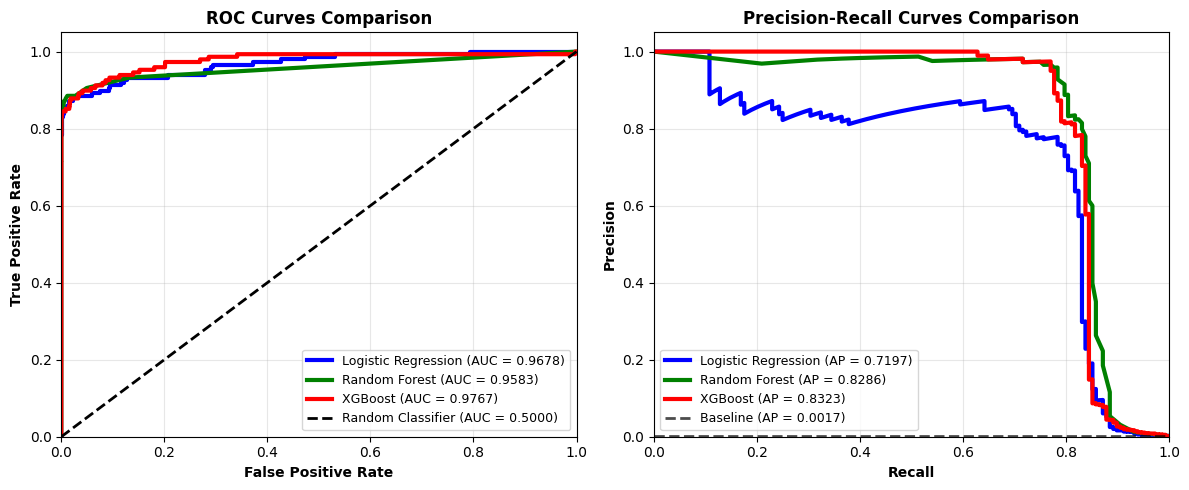

In [65]:
# Generate ROC curves for all models
plt.figure(figsize=(12, 5))

# ROC Curves
plt.subplot(1, 2, 1)
colors = ['blue', 'green', 'red', 'purple']
for idx, (name, result) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    auc_score = results[name]['AUC-ROC']
    plt.plot(fpr, tpr, color=colors[idx], lw=3,
             label=f'{name} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5000)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves Comparison', fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)

# Precision-Recall curves
plt.subplot(1, 2, 2)
for idx, (name, result) in enumerate(results.items()):
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    avg_precision = results[name]['Average Precision']
    plt.plot(recall, precision, color=colors[idx], lw=3,
             label=f'{name} (AP = {avg_precision:.4f})')

baseline_ap = y_test.mean()
plt.axhline(y=baseline_ap, color='k', linestyle='--', lw=2, alpha=0.7,
           label=f'Baseline (AP = {baseline_ap:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Precision-Recall Curves Comparison', fontweight='bold')
plt.legend(loc="lower left", fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Section 18: Threshold Optimization
**Purpose:** Find the classification threshold that balances fraud detection with false alarms according to business needs.  

In [66]:
# Threshold optimization for the best model
best_model = trained_models[best_model_name]
best_probas = results[best_model_name]['y_pred_proba']

print(f"=== THRESHOLD OPTIMIZATION FOR {best_model_name} ===")

# Calculate metrics for different thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
threshold_results = []

for threshold in thresholds:
    y_pred_thresh = (best_probas >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    threshold_results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    })

threshold_df = pd.DataFrame(threshold_results)

# Find optimal threshold based on F1 score
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']

print(f"Optimal threshold based on F1-score: {optimal_threshold:.2f}")
print(f"Optimal F1-score: {threshold_df.loc[optimal_idx, 'f1']:.4f}")
print(f"Precision at optimal threshold: {threshold_df.loc[optimal_idx, 'precision']:.4f}")
print(f"Recall at optimal threshold: {threshold_df.loc[optimal_idx, 'recall']:.4f}")


=== THRESHOLD OPTIMIZATION FOR XGBoost ===
Optimal threshold based on F1-score: 0.95
Optimal F1-score: 0.8604
Precision at optimal threshold: 0.9744
Recall at optimal threshold: 0.7703


## Section 19: Feature Importance Analysis
**Purpose:** Identify which features contribute most to fraud detection.  

In [67]:
# Extract feature importance from tree-based models
print("=== FEATURE IMPORTANCE ANALYSIS ===")

if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features - Random Forest:")
    print(rf_importance.head(15).to_string(index=False, float_format='%.6f'))

if 'XGBoost' in trained_models:
    xgb_model = trained_models['XGBoost']
    xgb_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features - XGBoost:")
    print(xgb_importance.head(15).to_string(index=False, float_format='%.6f'))


=== FEATURE IMPORTANCE ANALYSIS ===

Top 15 Most Important Features - Random Forest:
feature  importance
    V14    0.211784
    V10    0.127290
    V17    0.120224
    V12    0.103518
    V16    0.079307
    V11    0.057835
     V3    0.056516
     V4    0.038709
     V9    0.029386
     V2    0.022513
    V18    0.019697
     V7    0.017912
    V21    0.014393
     V5    0.008751
     V1    0.008093

Top 15 Most Important Features - XGBoost:
feature  importance
    V14    0.656361
    V17    0.055161
     V4    0.035647
    V10    0.030778
    V12    0.016079
     V1    0.015426
     V8    0.013691
     V7    0.011318
    V11    0.011305
    V26    0.011156
    V13    0.011082
   Time    0.010037
    V21    0.009345
    V27    0.008806
     V3    0.008690


## Section 20: Model Calibration for Production
**Purpose:** Adjust predicted probabilities so they better reflect actual risk.  

In [68]:
# Calibrate the best model for production use
print(f"=== MODEL CALIBRATION FOR {best_model_name} ===")

# Create calibrated classifier
calibrated_model = CalibratedClassifierCV(trained_models[best_model_name], method='isotonic', cv=3)
calibrated_model.fit(X_train_balanced, y_train_balanced)

# Get calibrated predictions
y_pred_calibrated = calibrated_model.predict(X_test_scaled)
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Compare calibrated vs uncalibrated performance
auc_calibrated = roc_auc_score(y_test, y_pred_proba_calibrated)
ap_calibrated = average_precision_score(y_test, y_pred_proba_calibrated)

print(f"Original Model Performance:")
print(f"  AUC-ROC: {results[best_model_name]['AUC-ROC']:.4f}")
print(f"  Average Precision: {results[best_model_name]['Average Precision']:.4f}")

print(f"\nCalibrated Model Performance:")
print(f"  AUC-ROC: {auc_calibrated:.4f}")
print(f"  Average Precision: {ap_calibrated:.4f}")


=== MODEL CALIBRATION FOR XGBoost ===
Original Model Performance:
  AUC-ROC: 0.9767
  Average Precision: 0.8323

Calibrated Model Performance:
  AUC-ROC: 0.9374
  Average Precision: 0.8270


## Section 21: Final Results and Recommendations

In [70]:
# Generate comprehensive final results
print("="*70)
print("CREDIT CARD FRAUD DETECTION - FINAL RESULTS SUMMARY")
print("="*70)

print(f"\nDATASET OVERVIEW:")
print(f"  Total Transactions: {len(df):,}")
print(f"  Fraudulent Transactions: {df['Class'].sum():,}")
print(f"  Fraud Rate: {df['Class'].mean()*100:.3f}%")
print(f"  Number of Features: {len(X.columns)}")

print(f"\nMODEL PERFORMANCE COMPARISON:")
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC-ROC': [results[name]['AUC-ROC'] for name in results.keys()],
    'Average Precision': [results[name]['Average Precision'] for name in results.keys()],
    'CV AUC-ROC': [cv_results[name]['mean_cv_score'] for name in results.keys()]
}).sort_values('AUC-ROC', ascending=False)

print(performance_df.to_string(index=False, float_format='%.4f'))

print(f"\nBEST PERFORMING MODEL: {best_model_name}")
best_result = results[best_model_name]
cm_best = confusion_matrix(y_test, best_result['y_pred'])
tn, fp, fn, tp = cm_best.ravel()

print(f"\nDETAILED PERFORMANCE METRICS ({best_model_name}):")
print(f"  AUC-ROC Score: {best_result['AUC-ROC']:.4f}")
print(f"  Average Precision Score: {best_result['Average Precision']:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.2f}")
print(f"  Fraud Detection Rate: {tp/(tp+fn)*100:.1f}%")
print(f"  False Alarm Rate: {fp/(fp+tn)*100:.3f}%")
print(f"  Overall Accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:.2f}%")

print(f"\nKEY IMPROVEMENTS IMPLEMENTED:")
print(f"  ✓ Proper train/test split before preprocessing (no data leakage)")
print(f"  ✓ Scaling fitted only on training data")
print(f"  ✓ SMOTE applied only to training data")
print(f"  ✓ Cross-validation with integrated preprocessing pipeline")
print(f"  ✓ Threshold optimization for production deployment")
print(f"  ✓ Model calibration for better probability estimates")

print(f"\nRECOMMENDATIONS FOR PRODUCTION:")
print(f"  1. Deploy {best_model_name} with calibrated probabilities")
print(f"  2. Use optimal threshold of {optimal_threshold:.2f} for binary classification")
print(f"  3. Implement real-time monitoring of model performance")
print(f"  4. Retrain model monthly with new fraud patterns")
print(f"  5. Consider ensemble methods for further improvement")
print(f"  6. Monitor false positive rates to minimize customer friction")


CREDIT CARD FRAUD DETECTION - FINAL RESULTS SUMMARY

DATASET OVERVIEW:
  Total Transactions: 284,807
  Fraudulent Transactions: 492
  Fraud Rate: 0.173%
  Number of Features: 30

MODEL PERFORMANCE COMPARISON:
              Model  AUC-ROC  Average Precision  CV AUC-ROC
            XGBoost   0.9767             0.8323      0.9778
Logistic Regression   0.9678             0.7197      0.9814
      Random Forest   0.9583             0.8286      0.9702

BEST PERFORMING MODEL: XGBoost

DETAILED PERFORMANCE METRICS (XGBoost):
  AUC-ROC Score: 0.9767
  Average Precision Score: 0.8323
  Optimal Threshold: 0.95
  Fraud Detection Rate: 79.1%
  False Alarm Rate: 0.028%
  Overall Accuracy: 99.94%

KEY IMPROVEMENTS IMPLEMENTED:
  ✓ Proper train/test split before preprocessing (no data leakage)
  ✓ Scaling fitted only on training data
  ✓ SMOTE applied only to training data
  ✓ Cross-validation with integrated preprocessing pipeline
  ✓ Threshold optimization for production deployment
  ✓ Model calibrat